<a href="https://colab.research.google.com/github/hannape/CNN-pierwsze-podejscie/blob/master/CNN_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
K.set_image_dim_ordering('th')
import numpy as np
from sklearn import preprocessing
from keras.datasets import mnist
import glob
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
X_train = numpy.load('drive/My Drive/X_train.npy')
y_train = numpy.load('drive/My Drive/y_train.npy')
X_test = numpy.load('drive/My Drive/X_test.npy')
y_test = numpy.load('drive/My Drive/y_test.npy')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

X_train = X_train.reshape(X_train.shape[0], 1, 60, 87).astype('float32')
X_val = X_val.reshape(X_val.shape[0], 1, 60, 87).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 60, 87).astype('float32')
print (X_train.shape)
print (X_test.shape)
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_val = 
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)


y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [0]:
a = 1905
y_train[a,1]==1
print(y_train)
b = numpy.where(y_train[:,1]== 1)[0]
print(b[0:10])

plt.imshow(X_train[407,0], cmap=plt.get_cmap('jet'))


In [0]:
del model
def larger_model():
  model = Sequential()
  model.add(Conv2D(20, (3,3), input_shape=(1, 60, 87), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(20, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(20, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
  

In [0]:
#@title
import keras
from sklearn.metrics import roc_auc_score

class Histories(keras.callbacks.Callback):
	def on_train_begin(self, logs={}):
		self.aucs = []
		self.losses = []

	def on_train_end(self, logs={}):
		return

	def on_epoch_begin(self, epoch, logs={}):
		return

	def on_epoch_end(self, epoch, logs={}):
		self.losses.append(logs.get('loss'))
		y_pred = self.model.predict(self.validation_data[0])
		self.aucs.append(roc_auc_score(self.validation_data[1], y_pred))
		a = (roc_auc_score(self.validation_data[1], y_pred))
		print(" AUC_on_val: %f " % a)
		return

	def on_batch_begin(self, batch, logs={}):
		return

	def on_batch_end(self, batch, logs={}):    return


Train on 24464 samples, validate on 6117 samples
Epoch 1/30
24464/24464 [==============================] - 19s 783us/step - loss: 0.1073 - acc: 0.9811 - val_loss: 0.0888 - val_acc: 0.9820
 AUC_on_val: 0.560661 
Epoch 2/30
24464/24464 [==============================] - 15s 613us/step - loss: 0.0964 - acc: 0.9816 - val_loss: 0.0954 - val_acc: 0.9820
 AUC_on_val: 0.530583 
Epoch 3/30
24464/24464 [==============================] - 15s 624us/step - loss: 0.0969 - acc: 0.9816 - val_loss: 0.0906 - val_acc: 0.9820
 AUC_on_val: 0.509247 
Epoch 4/30
24464/24464 [==============================] - 15s 618us/step - loss: 0.0952 - acc: 0.9816 - val_loss: 0.1000 - val_acc: 0.9820
 AUC_on_val: 0.523797 
Epoch 5/30
24464/24464 [==============================] - 15s 601us/step - loss: 0.0947 - acc: 0.9816 - val_loss: 0.0913 - val_acc: 0.9820
 AUC_on_val: 0.524308 
Epoch 6/30
24464/24464 [==============================] - 15s 620us/step - loss: 0.0938 - acc: 0.9816 - val_loss: 0.0911 - val_acc: 0.9820
 A

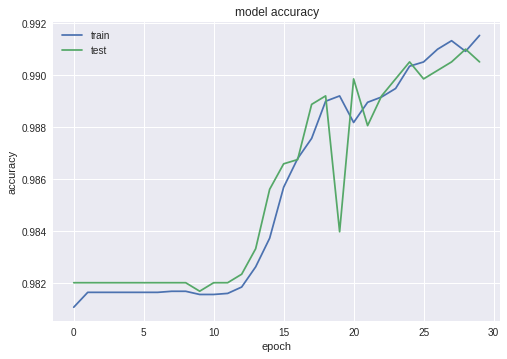

AUC: 0.788


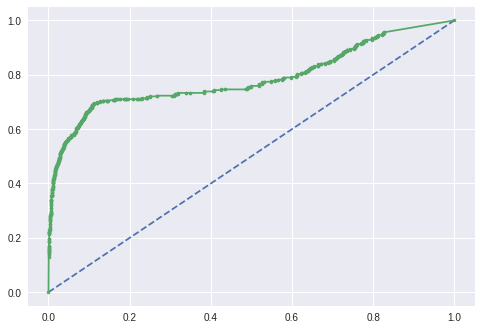

In [352]:
# build the model
model = larger_model()
# Fit the model
histories = Histories()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[histories])
print(histories.aucs)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# calculate AUC
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
y_test2 = numpy.load('drive/My Drive/y_test.npy')  # osobno, bo inny wymiar

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()


In [0]:
pyplot.plot(0:1:14,history.history.keys())
# show the plot
pyplot.show()

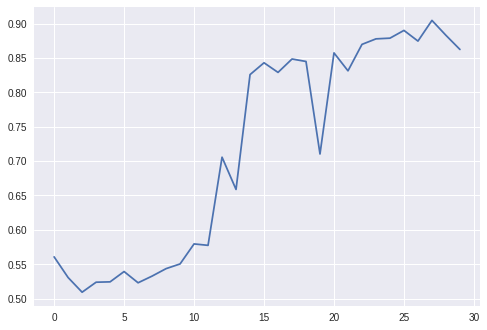

In [357]:
plt.plot(c)
pyplot.show()

In [0]:
model.save('drive/My Drive/Colab Notebooks/models/CNN_30e.h5')

In [0]:
model.save_weights('drive/My Drive/Colab Notebooks/models/CNN_30e_weights.h5')

In [0]:
del model